#main

In [ ]:
!pip install pyspark

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from pyspark.sql import SparkSession
from pyspark.sql.functions import col, mean, stddev, when,sum
from pyspark.ml.feature import StandardScaler, VectorAssembler, StringIndexer
from pyspark.sql import functions as F
from pyspark.sql.types import DoubleType, IntegerType
from pyspark.sql.functions import countDistinct
from pyspark.sql.functions import count, desc
from pyspark.ml import Pipeline
from pyspark.ml.classification import RandomForestClassifier, GBTClassifier
from pyspark.ml.evaluation import MulticlassClassificationEvaluator
from pyspark.ml.evaluation import MulticlassClassificationEvaluator, BinaryClassificationEvaluator
from pyspark.ml.stat import Correlation
from pyspark.ml.tuning import ParamGridBuilder, CrossValidator
from pyspark.mllib.evaluation import MulticlassMetrics
from sklearn.metrics import roc_curve, auc
from pyspark import SparkConf
from tqdm import tqdm

In [ ]:
# hide warnings
import warnings
warnings.filterwarnings('ignore')

In [ ]:
conf = SparkConf() \
    .setAppName("PySparkOptimization") \
    .set("spark.executor.memory", "2g") \
    .set("spark.driver.memory", "2g") \
    .set("spark.executor.cores", "2") \
    .set("spark.sql.shuffle.partitions", "8") \
    .set("spark.sql.shuffle.partitions", "8")  # Kurangi jumlah partisi saat shuffle


In [ ]:
# 1. Inisialisasi Spark Session

spark = SparkSession.builder.config(conf=conf) \
    .appName("Klasifikasi Genre") \
    .getOrCreate()

In [ ]:
# 2. Load Dataset
# Pastikan path diarahkan ke file CSV dataset Spotify yang ada
data_path = "/content/spotify_songs2.csv"
df = spark.read.csv(data_path, header=True, inferSchema=True)

In [ ]:
# 3. Eksplorasi Awal
df.printSchema()  # Melihat struktur dataset
df.show(5)        # Menampilkan 5 baris pertama

root
 |-- track_id: string (nullable = true)
 |-- track_name: string (nullable = true)
 |-- track_artist: string (nullable = true)
 |-- track_popularity: integer (nullable = true)
 |-- track_album_id: string (nullable = true)
 |-- track_album_name: string (nullable = true)
 |-- track_album_release_date: string (nullable = true)
 |-- playlist_name: string (nullable = true)
 |-- playlist_id: string (nullable = true)
 |-- playlist_genre: string (nullable = true)
 |-- playlist_subgenre: string (nullable = true)
 |-- danceability: string (nullable = true)
 |-- energy: string (nullable = true)
 |-- key: string (nullable = true)
 |-- loudness: string (nullable = true)
 |-- mode: string (nullable = true)
 |-- speechiness: double (nullable = true)
 |-- acousticness: double (nullable = true)
 |-- instrumentalness: double (nullable = true)
 |-- liveness: double (nullable = true)
 |-- valence: double (nullable = true)
 |-- tempo: double (nullable = true)
 |-- duration_ms: double (nullable = true)


In [ ]:
# Deskripsi Statistik
df.describe().toPandas()



,summary,track_id,track_name,track_artist,track_popularity,track_album_id,track_album_name,track_album_release_date,playlist_name,playlist_id,...,key,loudness,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo,duration_ms
0,count,32833,32833,32833,32833,32833,32833,32833,32833,32833,...,32833,32833,32833,32833,32833,32833,32833,32833,32833,32833
1,mean,None,Infinity,1182.5,42.477080985593766,None,Infinity,1994.0409703504042,None,None,...,5.373788742690058,-6.714960343567283,0.5617789047270955,0.10728242012609311,0.17532551997076137,0.08503226869460623,0.18983626717022573,0.5104382800840634,120.82878928517026,225681.46748989128
2,stddev,None,NaN,1994.7120166609927,24.984074486186916,None,NaN,12.936924530888342,None,None,...,3.612248908638986,2.9918276920539455,0.539370414665492,0.10228729983665304,0.21964117970063668,0.228459929884962,0.16638032885544798,0.2332299215566853,26.993193516792292,59936.563622578535
3,min,0017A6SJgTbfQVU2EtsPNo,"""""""I TRIED FOR YEARS... NOBODY LISTENED""""""",!!!,0,000YOrgQoB5IiiH95Yb8vY,!,"My Love!""""""",Niedermeier & Whitehead,Si-Tew,...,0,-0.046,-10.425,0.0,0.0,0.0,-11.062,0.0,0.0,0.0116
4,max,7zzZmpw8L66ZPjH1M6qmOs,하드캐리 Hard Carry,香取慎吾,100,7zygyMUltFYOvHoT3NOTsj,화양연화 The Most Beautiful Moment In Life: Young ...,2020-01-29,🤩🤪Post Teen Pop🤪🤩,indie poptimism,...,9,edm,progressive electro house,1.0,0.994,8.0,0.996,1.0,239.44,517810.0


In [ ]:
from pyspark.sql.functions import col  # Re-import col

null_counts = df.select([F.sum(F.col(c).isNull().cast("int")).alias(c) for c in df.columns])
null_counts.show()

+--------+----------+------------+----------------+--------------+----------------+------------------------+-------------+-----------+--------------+-----------------+------------+------+---+--------+----+-----------+------------+----------------+--------+-------+-----+-----------+
|track_id|track_name|track_artist|track_popularity|track_album_id|track_album_name|track_album_release_date|playlist_name|playlist_id|playlist_genre|playlist_subgenre|danceability|energy|key|loudness|mode|speechiness|acousticness|instrumentalness|liveness|valence|tempo|duration_ms|
+--------+----------+------------+----------------+--------------+----------------+------------------------+-------------+-----------+--------------+-----------------+------------+------+---+--------+----+-----------+------------+----------------+--------+-------+-----+-----------+
|       0|         0|           0|               0|             0|               0|                       0|            0|          0|             0|  

In [ ]:
# Cek jumlah baris dan kolom
print(f"Jumlah baris: {df.count()}, Jumlah kolom: {len(df.columns)}")

Jumlah baris: 32833, Jumlah kolom: 23


In [ ]:
# Cek nilai duplikat pada seluruh kolom
duplicate_rows = df.groupBy('track_id').count().filter("count > 1")
duplicate_rows.show()


# Menghitung jumlah baris duplikat
jumlah_duplikat = duplicate_rows.count()
print(f"Jumlah baris duplikat: {jumlah_duplikat}")

+--------------------+-----+
|            track_id|count|
+--------------------+-----+
|0r7CVbZTWZgbTCYdf...|    2|
|3iJeF2izF1QcpCgUc...|    2|
|1EJgymgJHcjSOGSHc...|    2|
|3kgKVcBpBGuSeaEC0...|    2|
|575NJxNUVDqwJGdzB...|    2|
|1NDxZ7cFAo481dtYW...|    3|
|7iNIg7XDEaYECfWD5...|    2|
|5N5k9nd479b1xpDZ4...|    2|
|0qaWEvPkts34WF68r...|    8|
|61ZM92T2zaXIVsqnc...|    2|
|7FjZU7XFs7P9jHI9Z...|    3|
|7N06jo3EnV792VFaG...|    4|
|3jwQwGVERUXo7eaAg...|    2|
|0GRoERSBBky3YgdKW...|    2|
|4fK2NU9UyQJV74ZGi...|    3|
|1IjuevPDJ8Sa97wFw...|    2|
|5ow0sNF1zSqp71Ix5...|    2|
|25sgk305KZfyuqVBQ...|    5|
|2ZEqEHPOhJdkI9pCC...|    2|
|5sbooPcNgIE22DwO0...|    2|
+--------------------+-----+
only showing top 20 rows

Jumlah baris duplikat: 3166


In [ ]:
df = df.dropDuplicates(['track_id'])

In [ ]:
# Cek jumlah baris dan kolom
print(f"Jumlah baris: {df.count()}, Jumlah kolom: {len(df.columns)}")

Jumlah baris: 28356, Jumlah kolom: 23


In [ ]:
# prompt: tampilkan describe dan sum dari dataset

# Display summary statistics
df.describe().show()

+-------+--------------------+--------------------+------------------+------------------+--------------------+------------------------+------------------------+--------------------+---------------+--------------------+------------------+------------------+--------------------+-----------------+------------------+--------------------+-------------------+-------------------+-------------------+-------------------+-------------------+------------------+------------------+
|summary|            track_id|          track_name|      track_artist|  track_popularity|      track_album_id|        track_album_name|track_album_release_date|       playlist_name|    playlist_id|      playlist_genre| playlist_subgenre|      danceability|              energy|              key|          loudness|                mode|        speechiness|       acousticness|   instrumentalness|           liveness|            valence|             tempo|       duration_ms|
+-------+--------------------+--------------------+-

In [ ]:
# Filter out rows where 'mode' is not 0 or 1
df = df.filter((df["mode"] == 0) | (df["mode"] == 1))

In [ ]:
# Identifikasi kolom yang seharusnya numerik
numeric_cols = ['mode','track_popularity','danceability', 'energy','key','loudness','speechiness','acousticness','instrumentalness','liveness','valence','duration_ms', 'tempo']  # Sesuaikan dengan kolom di dataset Anda


In [ ]:
# Ganti nilai tidak valid (misalnya string kosong atau null) dengan 0
for col in numeric_cols:
    df = df.withColumn(col, F.col(col).cast(DoubleType()))


In [ ]:
# Verifikasi perubahan tipe data
df.select(numeric_cols).printSchema()
df.select(numeric_cols).show(5)

root
 |-- mode: double (nullable = true)
 |-- track_popularity: double (nullable = true)
 |-- danceability: double (nullable = true)
 |-- energy: double (nullable = true)
 |-- key: double (nullable = true)
 |-- loudness: double (nullable = true)
 |-- speechiness: double (nullable = true)
 |-- acousticness: double (nullable = true)
 |-- instrumentalness: double (nullable = true)
 |-- liveness: double (nullable = true)
 |-- valence: double (nullable = true)
 |-- duration_ms: double (nullable = true)
 |-- tempo: double (nullable = true)

+----+----------------+------------+------+----+--------+-----------+------------+----------------+--------+-------+-----------+-------+
|mode|track_popularity|danceability|energy| key|loudness|speechiness|acousticness|instrumentalness|liveness|valence|duration_ms|  tempo|
+----+----------------+------------+------+----+--------+-----------+------------+----------------+--------+-------+-----------+-------+
| 0.0|            24.0|       0.659| 0.794|10.0|

In [ ]:
#Encode kolom track_genre
from pyspark.ml.feature import StringIndexer
genre_indexer = StringIndexer(inputCol="playlist_genre", outputCol="genre_index")
df = genre_indexer.fit(df).transform(df)

In [ ]:
df.select("playlist_genre", "genre_index").distinct().show()


+--------------+-----------+
|playlist_genre|genre_index|
+--------------+-----------+
|           pop|        1.0|
|          rock|        4.0|
|         latin|        5.0|
|           edm|        2.0|
|           rap|        0.0|
|           r&b|        3.0|
+--------------+-----------+



In [ ]:
# Filter the DataFrame to include only specified genres
allowed_genres = ["r&b", "pop", "edm", "rap", "rock", "latin"]
df = df.filter(df["playlist_genre"].isin(allowed_genres))

# Verify the changes (optional)
unique_genres_df = df.select("playlist_genre").distinct()
unique_genres_df.show(unique_genres_df.count(), truncate=False)

+--------------+
|playlist_genre|
+--------------+
|pop           |
|rap           |
|latin         |
|edm           |
|rock          |
|r&b           |
+--------------+



In [ ]:
df.select("playlist_genre", "genre_index").distinct().show()


+--------------+-----------+
|playlist_genre|genre_index|
+--------------+-----------+
|           pop|        1.0|
|          rock|        4.0|
|         latin|        5.0|
|           edm|        2.0|
|           rap|        0.0|
|           r&b|        3.0|
+--------------+-----------+



In [ ]:
# Instead of using append with two arguments, append each element individually:
numeric_cols.append("genre_index")

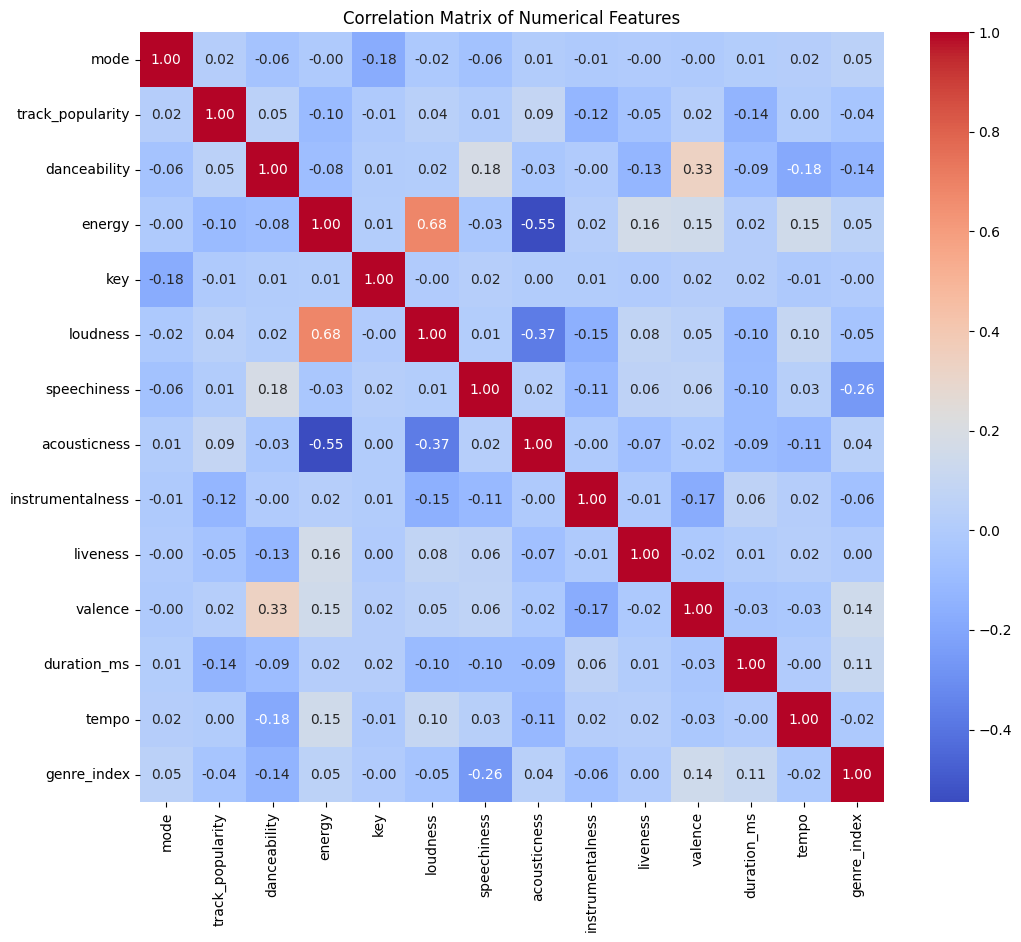

In [ ]:
# Korelasi antar fitur numerik
correlation_matrix = df.select(numeric_cols).toPandas().corr()

# Plot Heatmap
plt.figure(figsize=(12, 10))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f")
plt.title('Correlation Matrix of Numerical Features')
plt.show()

In [ ]:
# Drop kolom yang tidak diperlukan
columns_to_drop = ['track_id','track_album_id', 'track_album_release_date', 'playlist_id']
df = df.drop(*columns_to_drop)

df.printSchema()
df.show(5)
df.printSchema()
df.show(5)

root
 |-- track_name: string (nullable = true)
 |-- track_artist: string (nullable = true)
 |-- track_popularity: double (nullable = true)
 |-- track_album_name: string (nullable = true)
 |-- playlist_name: string (nullable = true)
 |-- playlist_genre: string (nullable = true)
 |-- playlist_subgenre: string (nullable = true)
 |-- danceability: double (nullable = true)
 |-- energy: double (nullable = true)
 |-- key: double (nullable = true)
 |-- loudness: double (nullable = true)
 |-- mode: double (nullable = true)
 |-- speechiness: double (nullable = true)
 |-- acousticness: double (nullable = true)
 |-- instrumentalness: double (nullable = true)
 |-- liveness: double (nullable = true)
 |-- valence: double (nullable = true)
 |-- tempo: double (nullable = true)
 |-- duration_ms: double (nullable = true)
 |-- genre_index: double (nullable = false)

+--------------------+------------------+----------------+----------------+--------------------+--------------+-----------------+------------

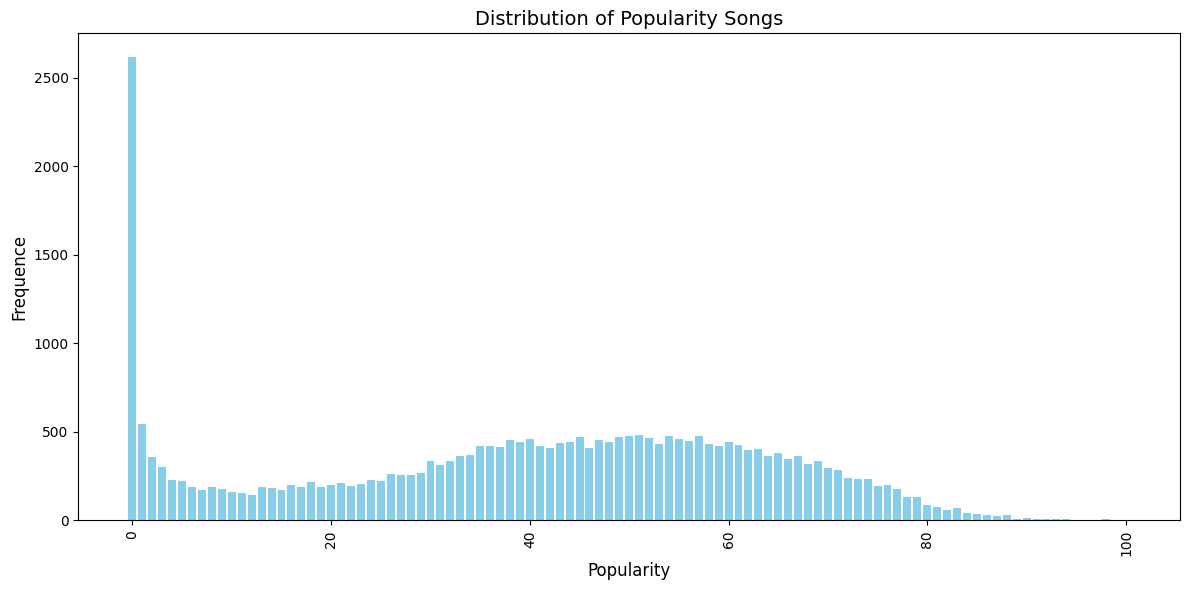

In [ ]:
# Calculate genre counts and convert to Pandas DataFrame
genre_counts = df.groupBy("track_popularity").count().orderBy(desc("count"))  # Make sure you use 'track_genre' here
genre_counts_pd = genre_counts.toPandas()

# ... (rest of your plotting code)

plt.figure(figsize=(12, 6))  # Adjust figure size for better visualization
plt.bar(genre_counts_pd['track_popularity'], genre_counts_pd['count'], color='skyblue')  # Use track_genre instead of genre
plt.xlabel('Popularity', fontsize=12) # Customize font size
plt.ylabel('Frequence', fontsize=12)
plt.title('Distribution of Popularity Songs', fontsize=14) # More descriptive title
plt.xticks(rotation=90, fontsize=10) # Rotate x-axis labels and adjust font size
plt.tight_layout() # Prevent labels from overlapping
plt.show()

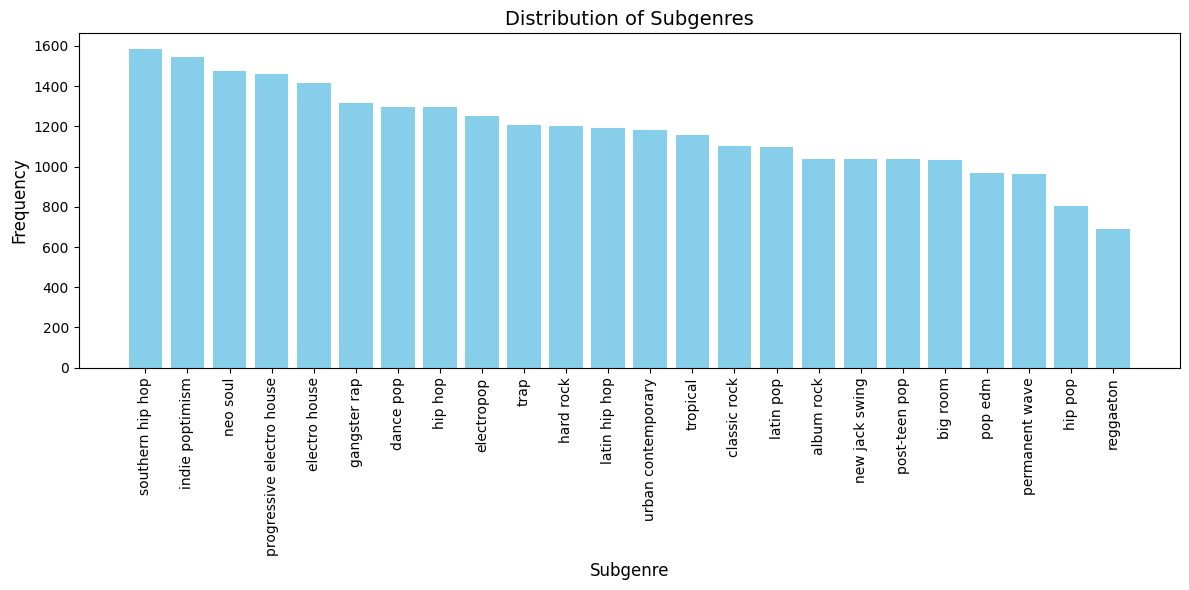

In [ ]:
# prompt: buat grafik EDA untuk melihat distribusi subgenre

# Calculate subgenre counts and convert to Pandas DataFrame
subgenre_counts = df.groupBy("playlist_subgenre").count().orderBy(desc("count"))
subgenre_counts_pd = subgenre_counts.toPandas()

# Plotting the distribution of subgenres
plt.figure(figsize=(12, 6))
plt.bar(subgenre_counts_pd['playlist_subgenre'], subgenre_counts_pd['count'], color='skyblue')
plt.xlabel('Subgenre', fontsize=12)
plt.ylabel('Frequency', fontsize=12)
plt.title('Distribution of Subgenres', fontsize=14)
plt.xticks(rotation=90, fontsize=10)
plt.tight_layout()
plt.show()

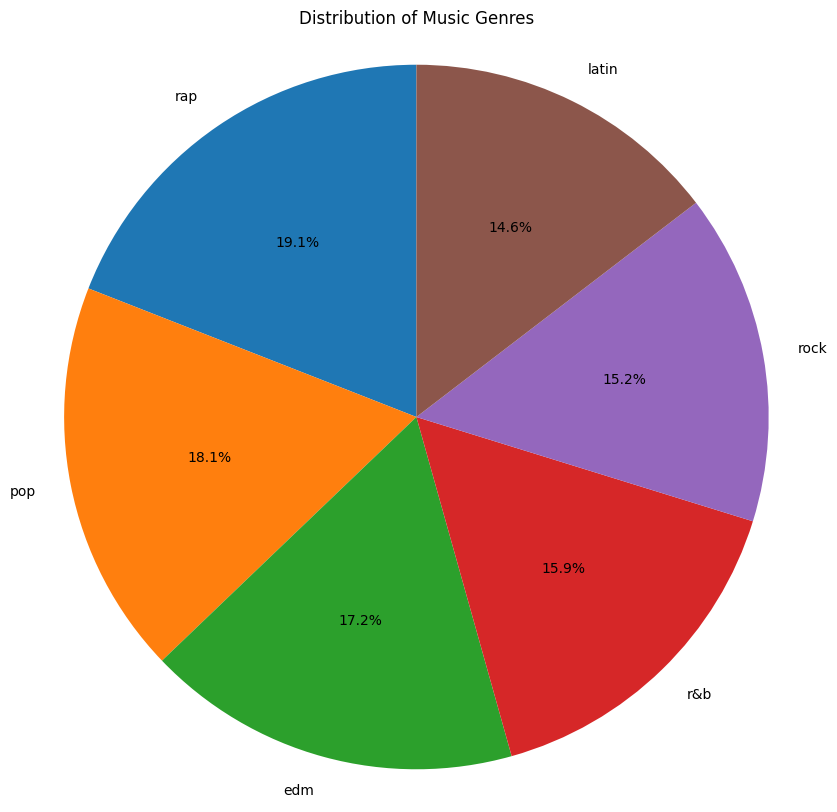

In [ ]:
# prompt: buatkan piechart untuk melihat genre lagu

# Calculate genre counts and convert to Pandas DataFrame
genre_counts = df.groupBy("playlist_genre").count().orderBy(desc("count"))
genre_counts_pd = genre_counts.toPandas()

# Create the pie chart
plt.figure(figsize=(10, 10))
plt.pie(genre_counts_pd['count'], labels=genre_counts_pd['playlist_genre'], autopct='%1.1f%%', startangle=90)
plt.title('Distribution of Music Genres')
plt.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.
plt.show()

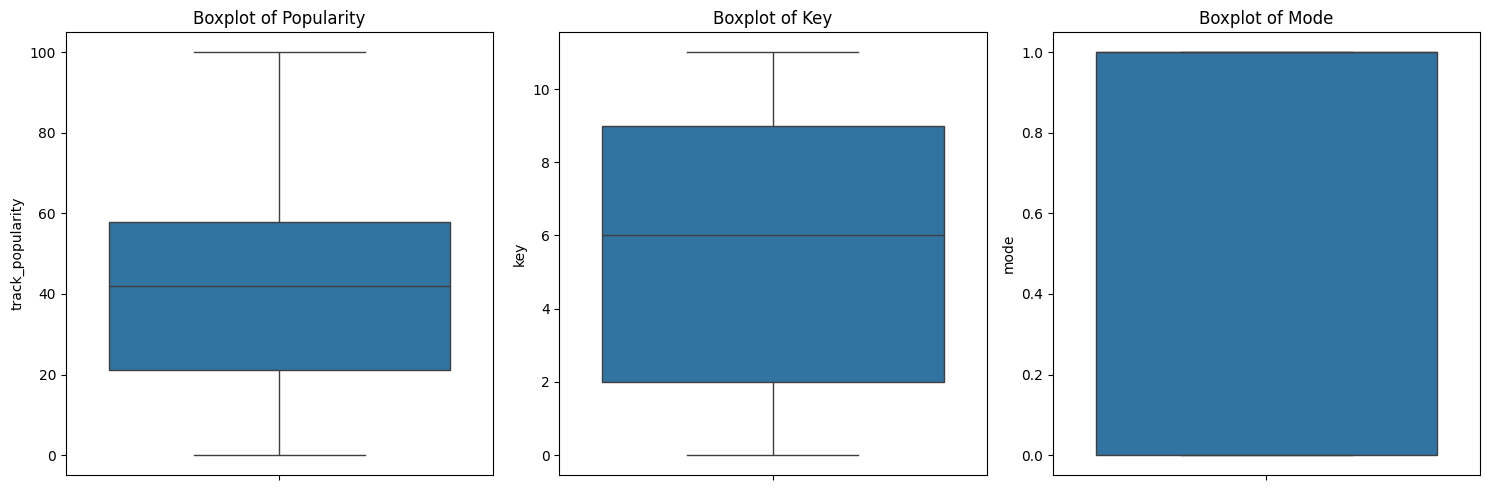

In [ ]:
# prompt: tampilkan boxplot untuk popularity,key and mode

# Convert the necessary columns to pandas Series for plotting
popularity_series = df.select("track_popularity").toPandas()["track_popularity"]
key_series = df.select("key").toPandas()["key"]
mode_series = df.select("mode").toPandas()["mode"]

# Create the boxplots
plt.figure(figsize=(15, 5))

plt.subplot(1, 3, 1)
sns.boxplot(y=popularity_series)
plt.title("Boxplot of Popularity")

plt.subplot(1, 3, 2)
sns.boxplot(y=key_series)
plt.title("Boxplot of Key")

plt.subplot(1, 3, 3)
sns.boxplot(y=mode_series)
plt.title("Boxplot of Mode")

plt.tight_layout()
plt.show()

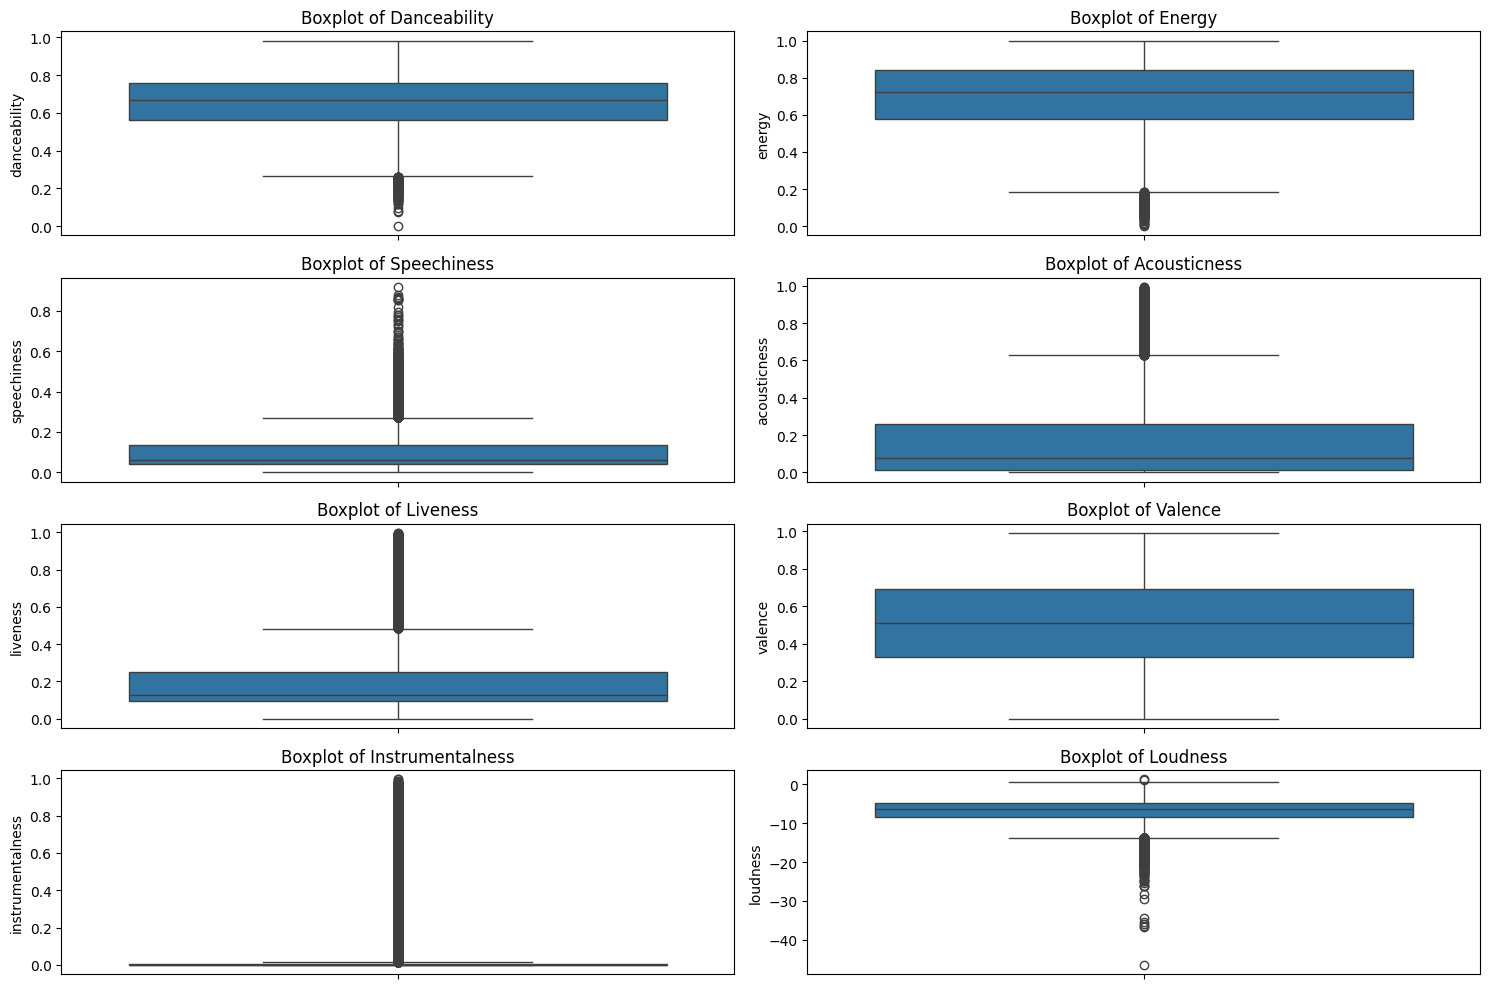

In [ ]:
# prompt: buat boxplot untuk melihat outlier di kolom danceability, energy, speechiess,acousticness,liveness,valence

# Convert the necessary columns to pandas Series for plotting
danceability_series = df.select("danceability").toPandas()["danceability"]
energy_series = df.select("energy").toPandas()["energy"]
speechiness_series = df.select("speechiness").toPandas()["speechiness"]
acousticness_series = df.select("acousticness").toPandas()["acousticness"]
liveness_series = df.select("liveness").toPandas()["liveness"]
valence_series = df.select("valence").toPandas()["valence"]
instrumentalness_series = df.select("instrumentalness").toPandas()["instrumentalness"]
loudness_series = df.select("loudness").toPandas()["loudness"]
# Create the boxplots
plt.figure(figsize=(15, 10))

plt.subplot(4, 2, 1) # Changed to a 4x2 grid to accommodate 8 subplots
sns.boxplot(y=danceability_series)
plt.title("Boxplot of Danceability")

plt.subplot(4, 2, 2) # Changed to a 4x2 grid to accommodate 8 subplots
sns.boxplot(y=energy_series)
plt.title("Boxplot of Energy")

plt.subplot(4, 2, 3) # Changed to a 4x2 grid to accommodate 8 subplots
sns.boxplot(y=speechiness_series)
plt.title("Boxplot of Speechiness")

plt.subplot(4, 2, 4) # Changed to a 4x2 grid to accommodate 8 subplots
sns.boxplot(y=acousticness_series)
plt.title("Boxplot of Acousticness")

plt.subplot(4, 2, 5) # Changed to a 4x2 grid to accommodate 8 subplots
sns.boxplot(y=liveness_series)
plt.title("Boxplot of Liveness")

plt.subplot(4, 2, 6) # Changed to a 4x2 grid to accommodate 8 subplots
sns.boxplot(y=valence_series)
plt.title("Boxplot of Valence")

plt.subplot(4, 2, 7) # Changed to a 4x2 grid to accommodate 8 subplots
sns.boxplot(y=instrumentalness_series)
plt.title("Boxplot of Instrumentalness") # Changed title to match the variable

plt.subplot(4, 2, 8) # Changed to a 4x2 grid to accommodate 8 subplots
sns.boxplot(y=loudness_series)
plt.title("Boxplot of Loudness") # Changed title to match the variable

plt.tight_layout()
plt.show()

# Bersihkan data outlier

In [ ]:
# List of columns to check
columns_to_check = ['danceability', 'energy','speechiness','acousticness','liveness','valence','track_popularity', 'key', 'mode', 'instrumentalness']

# Iterate over each column and print max and min values
for column in columns_to_check:
    # Access data from the 'df' DataFrame using select and toPandas()
    max_value = df.select(column).toPandas()[column].max()
    min_value = df.select(column).toPandas()[column].min()
    print(f"Column: {column} - Max: {max_value}, Min: {min_value}")

Column: danceability - Max: 0.983, Min: 0.0
Column: energy - Max: 1.0, Min: 0.000175
Column: speechiness - Max: 0.918, Min: 0.0
Column: acousticness - Max: 0.994, Min: 0.0
Column: liveness - Max: 0.996, Min: 0.0
Column: valence - Max: 0.991, Min: 0.0
Column: track_popularity - Max: 100.0, Min: 0.0
Column: key - Max: 11.0, Min: 0.0
Column: mode - Max: 1.0, Min: 0.0
Column: instrumentalness - Max: 0.994, Min: 0.0


In [ ]:
from pyspark.sql.functions import col

# Fungsi untuk menghitung batas bawah dan atas berdasarkan IQR
def calculate_iqr_bounds(df, column):
    Q1 = df.approxQuantile(column, [0.25], 0.01)[0]
    Q3 = df.approxQuantile(column, [0.75], 0.01)[0]
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    return lower_bound, upper_bound

# Contoh untuk kolom "danceability"
# Changed 'data' to 'df' to use the defined DataFrame
lower_bound, upper_bound = calculate_iqr_bounds(df, "danceability")
print(f"Danceability - Lower Bound: {lower_bound}, Upper Bound: {upper_bound}")

Danceability - Lower Bound: 0.2660000000000001, Upper Bound: 1.0499999999999998


In [ ]:
df = df.withColumn(
    "danceability",
    when(col("danceability") < lower_bound, lower_bound)
    .when(col("danceability") > upper_bound, upper_bound)
    .otherwise(col("danceability"))
)


In [ ]:
# Hitung batas bawah dan atas untuk kolom 'energy'
lower_bound, upper_bound = calculate_iqr_bounds(df, "energy")
print(f"Energy - Lower Bound: {lower_bound}, Upper Bound: {upper_bound}")

Energy - Lower Bound: 0.18649999999999994, Upper Bound: 1.2305


In [ ]:
from pyspark.sql.functions import col  # Re-import col

df = df.withColumn(
    "energy",
    when(col("energy") < lower_bound, lower_bound)
    .when(col("energy") > upper_bound, upper_bound)
    .otherwise(col("energy"))
)

In [ ]:
lower_bound, upper_bound = calculate_iqr_bounds(df, "speechiness")
print(f"Speechiness - Lower Bound: {lower_bound}, Upper Bound: {upper_bound}")

Speechiness - Lower Bound: -0.09125000000000003, Upper Bound: 0.26115


In [ ]:
df = df.withColumn(
    "speechiness",
    when(col("speechiness") < lower_bound, lower_bound)
    .when(col("speechiness") > upper_bound, upper_bound)
    .otherwise(col("speechiness"))
)

In [ ]:
lower_bound, upper_bound = calculate_iqr_bounds(df, "acousticness")
print(f"acousticness - Lower Bound: {lower_bound}, Upper Bound: {upper_bound}")

df = df.withColumn(
    "acousticness",
    when(col("acousticness") < lower_bound, lower_bound)
    .when(col("acousticness") > upper_bound, upper_bound)
    .otherwise(col("acousticness"))
)

acousticness - Lower Bound: -0.33675, Upper Bound: 0.59885


In [ ]:
lower_bound, upper_bound = calculate_iqr_bounds(df, "liveness")
print(f"liveness - Lower Bound: {lower_bound}, Upper Bound: {upper_bound}")

df = df.withColumn(
    "liveness",
    when(col("liveness") < lower_bound, lower_bound)
    .when(col("liveness") > upper_bound, upper_bound)
    .otherwise(col("liveness"))
)

liveness - Lower Bound: -0.132, Upper Bound: 0.46640000000000004


In [ ]:
from pyspark.sql.functions import col, when  # Re-import col to restore its functionality

lower_bound, upper_bound = calculate_iqr_bounds(df, "instrumentalness")
print(f"instrumentalness - Lower Bound: {lower_bound}, Upper Bound: {upper_bound}")

df = df.withColumn(
    "instrumentalness",
    when(col("instrumentalness") < lower_bound, lower_bound)
    .when(col("instrumentalness") > upper_bound, upper_bound)
    .otherwise(col("instrumentalness"))
)

instrumentalness - Lower Bound: -0.007875, Upper Bound: 0.013125000000000001


In [ ]:
from pyspark.sql.functions import col, when  # Re-import col to restore its functionality

lower_bound, upper_bound = calculate_iqr_bounds(df, "loudness")
print(f"loudness - Lower Bound: {lower_bound}, Upper Bound: {upper_bound}")

df = df.withColumn(
    "loudness",
    when(col("loudness") < lower_bound, lower_bound)
    .when(col("loudness") > upper_bound, upper_bound)
    .otherwise(col("loudness"))
)

loudness - Lower Bound: -13.6835, Upper Bound: 0.5925000000000002


In [ ]:
from pyspark.sql.functions import col, when  # Re-import col to restore its functionality

lower_bound, upper_bound = calculate_iqr_bounds(df, "tempo")
print(f"tempo - Lower Bound: {lower_bound}, Upper Bound: {upper_bound}")

df = df.withColumn(
    "tempo",
    when(col("tempo") < lower_bound, lower_bound)
    .when(col("tempo") > upper_bound, upper_bound)
    .otherwise(col("tempo"))
)

tempo - Lower Bound: 50.964500000000015, Upper Bound: 181.60049999999998


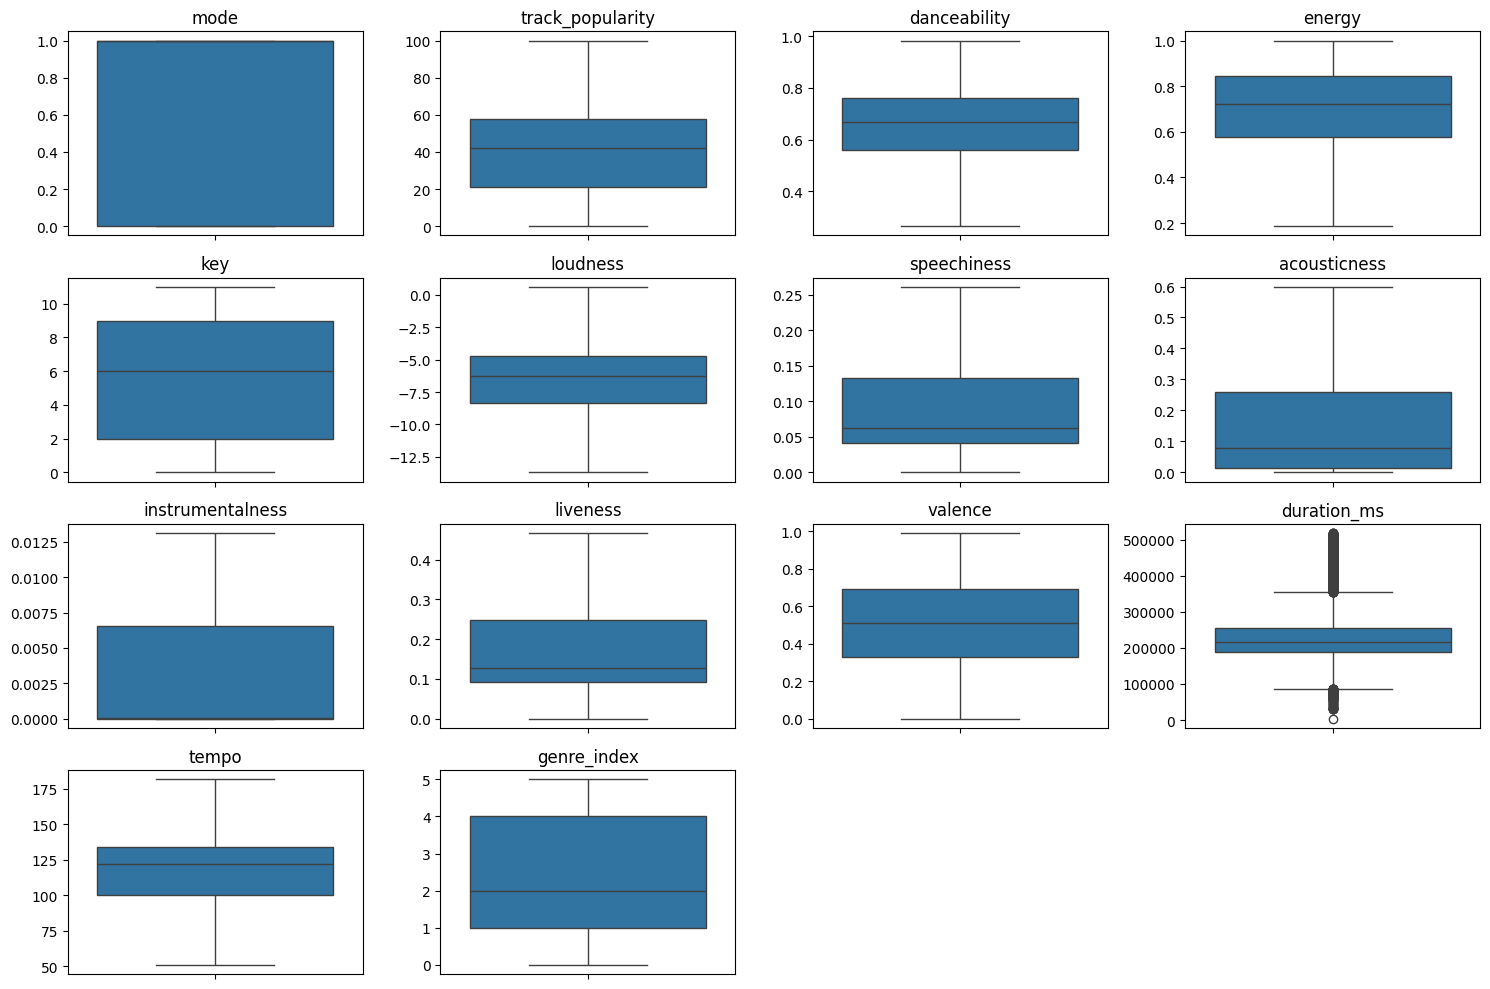

In [ ]:
# Create box plots for each numeric column
plt.figure(figsize=(15, 10))  # Adjust figure size as needed

# Adjust the grid layout to accommodate all 14 columns (e.g., 4 rows, 4 columns)
for i, col in enumerate(numeric_cols):
    plt.subplot(4, 4, i + 1)  # Changed to 4x4 grid
    # Use df[col] to access data from the DataFrame
    sns.boxplot(y=df.select(col).toPandas()[col])
    plt.title(col)
    plt.ylabel('')

plt.tight_layout()
plt.show()

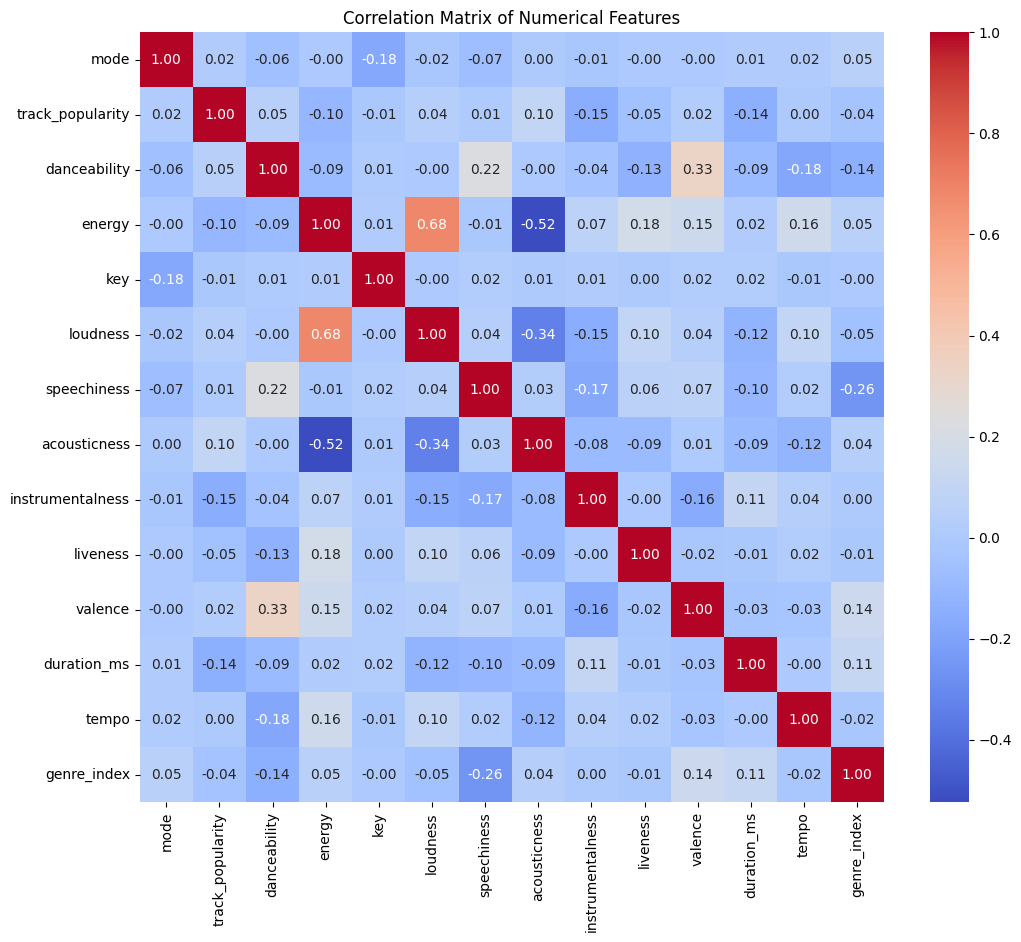

In [ ]:
# Korelasi antar fitur numerik
correlation_matrix = df.select(numeric_cols).toPandas().corr()

# Plot Heatmap
plt.figure(figsize=(12, 10))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f")
plt.title('Correlation Matrix of Numerical Features')
plt.show()

## Modelling

In [ ]:
features_cols = [col for col in numeric_cols if col != 'genre_index']

In [ ]:
# Assemble features into a vector
assembler = VectorAssembler(inputCols=features_cols, outputCol="features")

In [ ]:
# Split the data into training and testing sets
train_data, test_data = df.randomSplit([0.8, 0.2], seed=42)

In [ ]:
# Menggunakan genre_index sebagai label
df_prepared = assembler.transform(df)

#Random Forest

In [ ]:
# Create and train the RandomForestClassifier
rf = RandomForestClassifier(labelCol="genre_index", featuresCol="features", rawPredictionCol="rawPrediction", probabilityCol="probability",numTrees=50, maxDepth=10)

# Create a pipeline for the model
model_pipeline = Pipeline(stages=[assembler, rf])  # Include assembler in the pipeline

# Fit the model pipeline to the training data
model = model_pipeline.fit(train_data)

# Make predictions on the test data
predictions = model.transform(test_data)

In [ ]:
# Evaluate the model
evaluator = MulticlassClassificationEvaluator(labelCol="genre_index", predictionCol="prediction", metricName="accuracy")
accuracy = evaluator.evaluate(predictions)
print(f"Accuracy: {accuracy}")

#Further evaluation metrics
evaluator_f1 = MulticlassClassificationEvaluator(labelCol="genre_index", predictionCol="prediction", metricName="f1")
f1_score = evaluator_f1.evaluate(predictions)
print(f"F1-Score: {f1_score}")

evaluator_precision = MulticlassClassificationEvaluator(labelCol="genre_index", predictionCol="prediction", metricName="weightedPrecision")
precision = evaluator_precision.evaluate(predictions)
print(f"Precision: {precision}")

evaluator_recall = MulticlassClassificationEvaluator(labelCol="genre_index", predictionCol="prediction", metricName="weightedRecall")
recall = evaluator_recall.evaluate(predictions)
print(f"Recall: {recall}")

Accuracy: 0.5521527652675193
F1-Score: 0.5435901854287477
Precision: 0.5436074617246975
Recall: 0.5521527652675193


In [ ]:
# Sampling data
train_data_sampled = train_data.sample(fraction=0.3, seed=42)

In [ ]:


# Cache dataset
train_data_sampled.cache()

# Hyperparameter grid
param_grid = ParamGridBuilder() \
    .addGrid(rf.maxDepth, [5, 10]) \
    .addGrid(rf.maxBins, [32, 64]) \
    .addGrid(rf.numTrees, [20]) \
    .build()


# CrossValidator
crossval = CrossValidator(estimator=model_pipeline,
                          estimatorParamMaps=param_grid,
                          evaluator=evaluator,
                          numFolds=3,
                          parallelism=2)

evaluator = MulticlassClassificationEvaluator(labelCol="genre_index", metricName="accuracy")

# Training
cvModel = crossval.fit(train_data_sampled)

print(f"Best Model Parameters: {cvModel.bestModel.stages[-1]._java_obj.getMaxDepth()}, {cvModel.bestModel.stages[-1]._java_obj.getNumTrees()}")

Best Model Parameters: 10, 20


In [ ]:
# Evaluate the model
evaluator = MulticlassClassificationEvaluator(labelCol="genre_index", predictionCol="prediction", metricName="accuracy")
accuracy = evaluator.evaluate(predictions)
print(f"Accuracy: {accuracy}")

#Further evaluation metrics
evaluator_f1 = MulticlassClassificationEvaluator(labelCol="genre_index", predictionCol="prediction", metricName="f1")
f1_score = evaluator_f1.evaluate(predictions)
print(f"F1-Score: {f1_score}")

evaluator_precision = MulticlassClassificationEvaluator(labelCol="genre_index", predictionCol="prediction", metricName="weightedPrecision")
precision = evaluator_precision.evaluate(predictions)
print(f"Precision: {precision}")

evaluator_recall = MulticlassClassificationEvaluator(labelCol="genre_index", predictionCol="prediction", metricName="weightedRecall")
recall = evaluator_recall.evaluate(predictions)
print(f"Recall: {recall}")

Accuracy: 0.5486948694869487
F1-Score: 0.5414043973669187
Precision: 0.5444392756455999
Recall: 0.5486948694869487


In [ ]:
from sklearn.metrics import roc_auc_score, roc_curve, auc
import numpy as np

# Assuming 'predictions' DataFrame contains 'probability' column (vector of probabilities) and 'genre_index' column (true labels)
# Convert predictions and labels to NumPy arrays
y_true = predictions.select("genre_index").toPandas()["genre_index"].astype(int)  # Convert to integers

# **Get probabilities for all classes**
y_prob = predictions.select("probability").toPandas()["probability"].apply(lambda x: np.array(x)).to_list()
y_prob = np.array(y_prob) # Convert to a numpy array


# Calculate AUC (for multi-class, consider using 'ovr' or 'ovo' for multi_class parameter)
auc_score = roc_auc_score(y_true, y_prob, multi_class='ovr') # Calculate AUC for multiclass
print(f"AUC: {auc_score}")

AUC: 0.8041201271604811


# Gradient Boost Tree

In [ ]:
features_cols2 = [col for col in numeric_cols if col != 'mode']

In [ ]:
# Assemble features into a vector
assembler = VectorAssembler(inputCols=features_cols, outputCol="features2")

In [ ]:
# Split the data into training and testing sets
train_data, test_data = df.randomSplit([0.8, 0.2], seed=42)

In [ ]:
# Menggunakan genre_index sebagai label
df_prepared = assembler.transform(df)

In [ ]:
# Gradient Boosting Tree
gbt = GBTClassifier(labelCol="mode", featuresCol="features2")
pipeline_gbt = Pipeline(stages=[assembler, gbt])
model_gbt = pipeline_gbt.fit(train_data)

# Make predictions
predictions_gbt = model_gbt.transform(test_data)

# Evaluate the model
evaluator_gbt = MulticlassClassificationEvaluator(labelCol="mode", predictionCol="prediction", metricName="accuracy")
accuracy_gbt = evaluator_gbt.evaluate(predictions_gbt)
print(f"GBT Accuracy: {accuracy_gbt}")

# Further evaluation metrics for GBT
evaluator_f1_gbt = MulticlassClassificationEvaluator(labelCol="mode", predictionCol="prediction", metricName="f1")
f1_score_gbt = evaluator_f1_gbt.evaluate(predictions_gbt)
print(f"GBT F1-Score: {f1_score_gbt}")

evaluator_precision_gbt = MulticlassClassificationEvaluator(labelCol="mode", predictionCol="prediction", metricName="weightedPrecision")
precision_gbt = evaluator_precision_gbt.evaluate(predictions_gbt)
print(f"GBT Precision: {precision_gbt}")

evaluator_recall_gbt = MulticlassClassificationEvaluator(labelCol="mode", predictionCol="prediction", metricName="weightedRecall")
recall_gbt = evaluator_recall_gbt.evaluate(predictions_gbt)
print(f"GBT Recall: {recall_gbt}")

GBT Accuracy: 1.0
GBT F1-Score: 1.0
GBT Precision: 1.0
GBT Recall: 1.0


In [ ]:
y_true_gbt = predictions_gbt.select("mode").toPandas()["mode"].astype(int)

# Get probabilities for the positive class (mode=1)
y_prob_gbt = predictions_gbt.select("probability").toPandas()["probability"].apply(lambda x: x[1]).to_numpy()


# Calculate AUC for GBT
auc_score_gbt = roc_auc_score(y_true_gbt, y_prob_gbt)
print(f"GBT AUC: {auc_score_gbt}")

GBT AUC: 1.0


#kmeans

In [ ]:
from pyspark.ml.feature import MinMaxScaler

# Assuming 'features_cols' is defined as in your original code
features_cols = [col for col in numeric_cols if col != 'genre_index']

# Create a MinMaxScaler
scaler = MinMaxScaler(inputCol="features", outputCol="scaledFeatures")

# Create a VectorAssembler
assembler = VectorAssembler(inputCols=features_cols, outputCol="features")

# First, assemble features using VectorAssembler
df_prepared = assembler.transform(df) # df_prepared now has the 'features' column

# Then, fit and transform the data using the scaler
scalerModel = scaler.fit(df_prepared)  # Use df_prepared which now has the 'features' column
scaledData = scalerModel.transform(df_prepared)

In [ ]:
# Sampling data
train_data_sampled = df_prepared.sample(fraction=0.3, seed=42)

In [ ]:
from pyspark.ml.evaluation import ClusteringEvaluator # Import ClusteringEvaluator
from pyspark.sql import functions as F
from pyspark.ml.clustering import KMeans # Import KMeans

# Train a KMeans model.
kmeans = KMeans().setK(6).setSeed(1)  # Adjust k as needed
model = kmeans.fit(df_prepared)

# Make predictions
predictions = model.transform(df_prepared)

# Evaluate clustering by computing Silhouette score
evaluator = ClusteringEvaluator()
silhouette = evaluator.evaluate(predictions)
print("Silhouette with squared euclidean distance = " + str(silhouette))

# Shows the result.
centers = model.clusterCenters()
print("Cluster Centers: ")
for center in centers:
    print(center)

# Add genre labels based on prediction
genre_mapping = (
    F.when(F.col("prediction") == 0, "rap")
    .when(F.col("prediction") == 1, "pop")
    .when(F.col("prediction") == 2, "edm")
    .when(F.col("prediction") == 3, "r&b")
    .when(F.col("prediction") == 4, "rock")
    .when(F.col("prediction") == 5, "latin")
    .otherwise("unknown")  # Optional fallback
)

# Add a new column with genre names
result = predictions.withColumn("genre_label", genre_mapping)

# Select only relevant columns: features, prediction, and genre_label
result = result.select("track_name","track_artist","features", "prediction", "genre_label")

# Show the result
result.show(5, truncate=False)


Silhouette with squared euclidean distance = 0.6669523937556756
Cluster Centers: 
[ 5.87532840e-01  3.55818008e+01  6.41618581e-01  6.87768808e-01
  5.46166706e+00 -7.30213052e+00  9.29456174e-02  1.59084925e-01
  3.76910141e-03  1.79594512e-01  5.16431789e-01  2.83590350e+05
  1.19775421e+02]
[ 5.56022099e-01  4.22364641e+01  6.82764641e-01  6.71938232e-01
  5.30651934e+00 -6.94468862e+00  1.16851204e-01  1.98240992e-01
  4.29005663e-03  1.81124884e-01  5.00853905e-01  1.50596013e+05
  1.20621319e+02]
[ 6.07547170e-01  2.78396226e+01  6.36598113e-01  7.08385849e-01
  5.66415094e+00 -8.56427736e+00  7.35996226e-02  1.17104007e-01
  9.14653792e-03  1.67975283e-01  4.14633019e-01  4.45523979e+05
  1.23992250e+02]
[ 5.44288332e-01  3.07580941e+01  6.29364081e-01  6.83840257e-01
  5.55100794e+00 -7.83462340e+00  8.99493891e-02  1.39217054e-01
  5.93849452e-03  1.81734759e-01  4.73557117e-01  3.47390397e+05
  1.20383417e+02]
[ 5.70075266e-01  3.92697898e+01  6.46918116e-01  7.00973138e-01
 

In [ ]:
from pyspark.ml.clustering import KMeans
from pyspark.ml.evaluation import ClusteringEvaluator
from pyspark.ml.tuning import ParamGridBuilder, TrainValidationSplit

# Instantiate KMeans model
kmeans = KMeans(seed=1)  # Seed for reproducibility

# Create a parameter grid for hyperparameter tuning
paramGrid = ParamGridBuilder() \
    .addGrid(kmeans.k, [2, 3, 4, 5, 6, 7, 8]) \
    .addGrid(kmeans.maxIter, [10, 20, 30, 40, 50]) \
    .addGrid(kmeans.tol, [1e-4, 1e-5, 1e-6]) \
    .build()

# Define evaluator based on Silhouette score
evaluator = ClusteringEvaluator()

# Use TrainValidationSplit to select the best model
tvs = TrainValidationSplit(estimator=kmeans,
                           estimatorParamMaps=paramGrid,
                           evaluator=evaluator,

                           trainRatio=0.8)  # Use 80% of data for training, 20% for validation

# Fit the model on the training data
tvsModel = tvs.fit(train_data_sampled)

# Get the best model
bestModel = tvsModel.bestModel

# Evaluate the best model on test data
predictions = bestModel.transform(train_data_sampled)
silhouette = evaluator.evaluate(predictions)
print("Best Silhouette score: ", silhouette)

# Print the best parameters
print("Best number of clusters (k): ", bestModel.getK())
print("Best maxIter: ", bestModel.getMaxIter())
print("Best tol: ", bestModel.getTol())

# Optional: Explore the cluster centers of the best model
print("Cluster Centers: ")
for center in bestModel.clusterCenters():
    print(center)


Best Silhouette score:  0.7275409382815231
Best number of clusters (k):  2
Best maxIter:  10
Best tol:  0.0001
Cluster Centers: 
[ 5.64333716e-01  4.11522701e+01  6.59441567e-01  7.02577692e-01
  5.39223078e+00 -6.44840895e+00  1.03049238e-01  1.69888102e-01
  2.99202594e-03  1.78992018e-01  5.09960188e-01  1.96521743e+05
  1.21147486e+02]
[ 5.71143086e-01  3.45103917e+01  6.38436451e-01  6.91883094e-01
  5.52517986e+00 -7.39013869e+00  9.11110911e-02  1.53489237e-01
  4.39612590e-03  1.82595907e-01  5.08716867e-01  2.97354501e+05
  1.19883975e+02]


#gausian mixture

In [ ]:
# prompt: buatkan model gaussian mixture pyspark untuk clustering

from pyspark.ml.clustering import GaussianMixture
from pyspark.ml.evaluation import ClusteringEvaluator

# Assuming df_prepared is your DataFrame with assembled features
# ... (your existing code)

# Train a Gaussian Mixture Model
gmm = GaussianMixture().setK(6).setSeed(1)  # Adjust k as needed
model = gmm.fit(df_prepared)

# Make predictions
predictions = model.transform(df_prepared)

# Evaluate clustering by computing Silhouette score
evaluator = ClusteringEvaluator()
silhouette = evaluator.evaluate(predictions)
print("Silhouette with squared euclidean distance = " + str(silhouette))

# Shows the result.
print("Gaussian Mixture Model Cluster Centers: ")
for i, center in enumerate(model.gaussiansDF.select("mean").collect()):
    print(f"Cluster {i}: {center.mean}")


# Add genre labels based on prediction (adjust mappings as needed)
genre_mapping = (
    F.when(F.col("prediction") == 0, "rap")
    .when(F.col("prediction") == 1, "pop")
    .when(F.col("prediction") == 2, "edm")
    .when(F.col("prediction") == 3, "r&b")
    .when(F.col("prediction") == 4, "rock")
    .when(F.col("prediction") == 5, "latin")
    .otherwise("unknown")  # Optional fallback
)

# Add a new column with genre names
result = predictions.withColumn("genre_label", genre_mapping)

# Select only relevant columns: features, prediction, and genre_label
result = result.select("track_name","track_artist","features", "prediction", "genre_label")

# Show the result
result.show(5, truncate=False)

Silhouette with squared euclidean distance = -0.08874896293853837
Gaussian Mixture Model Cluster Centers: 
Cluster 0: [0.735915363319024,33.90400389574977,0.5609986538497828,0.8410514535813456,4.596723413618785,-11.05207907214219,0.0723423195707208,0.34683268104757564,0.011336680504559653,0.22281163827675543,0.21122337158026983,374137.17974237,124.22254653400118]
Cluster 1: [0.40096258404510704,26.952220210367997,0.6601512752586166,0.5990543577237452,5.787113147684743,-10.201028154380024,0.12389849733267387,0.2627997998650209,0.011370637768011735,0.17759949169432884,0.3803699624942604,354688.0270397617,130.14374170449264]
Cluster 2: [0.9999870313709802,36.68678778903471,0.6215406217784225,0.7873011312944923,4.77702828277519,-6.106461175995597,0.05527627841994354,0.020044957734278033,0.004991022246765373,0.18509121911747528,0.4943278228840922,235570.2367979094,123.86314909190861]
Cluster 3: [0.0003810161755026844,40.75280610318556,0.6778937003663207,0.6565302868649769,6.0784487285598425